# Finding blobs in 64x64 images using conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils
import os.path

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get data

Data reading function

In [2]:
shp=[15879,1,64,64,4]

good_data=utils.get_multichannel_image('/home/ubuntu/SAS_StemCell/good.tif_RotShift.tif', shp)


In [3]:
shp=[49569,1,64,64,4]

bad_data=utils.get_multichannel_image('/home/ubuntu/SAS_StemCell/bad_subset.tif', shp)

In [4]:
shp=[8897,1,64,64,4]

true_test_data=utils.get_multichannel_image('/home/ubuntu/SAS_StemCell/test.tif', shp)

In [5]:
shp=[64821,1,64,64,4]
true_test2_data=np.fromfile('/home/ubuntu/SAS_StemCell/test2.raw', np.float32)
true_test2_data=true_test2_data.reshape([64821,4,64,64])
true_test2_data=np.swapaxes(np.swapaxes(true_test2_data.byteswap(),1,2),2,3)

Setup training set (training_*)

In [6]:
training_goods=np.arange(0,60*201) #out of 79
training_bads=np.arange(0,40000)
training_good_subset=good_data[training_goods,:,:,:]
training_bad_subset=bad_data[training_bads, :,:,:]
training_list=np.concatenate((training_good_subset, training_bad_subset), axis=0)
training_truth=np.concatenate((np.ones((training_good_subset.shape[0],1)), np.zeros((training_bad_subset.shape[0],1))), axis=0)
training_truth=np.concatenate((training_truth,(1-training_truth)), axis=1)

Setup validation set (validation_*)

In [7]:
validation_goods=np.arange(60*201,70*201) #out of 79
validation_bads=np.arange(40000,47000)
validation_list=np.concatenate((good_data[validation_goods,:,:,:], bad_data[validation_bads, :,:,:]), axis=0)
validation_truth=np.concatenate((np.ones((len(validation_goods),1)), np.zeros((len(validation_bads),1))), axis=0)
validation_good_subset=good_data[validation_goods,:,:,:]
validation_bad_subset=bad_data[validation_bads, :,:,:]
validation_list=np.concatenate((validation_good_subset, validation_bad_subset), axis=0)
validation_truth=np.concatenate((np.ones((validation_good_subset.shape[0],1)), np.zeros((validation_bad_subset.shape[0],1))), axis=0)
validation_truth=np.concatenate((validation_truth,(1-validation_truth)), axis=1)

In [8]:
test_goods=np.arange(70*201,78*201) #out of 79
test_bads=np.arange(47000,49000)
test_list=np.concatenate((good_data[test_goods,:,:,:], bad_data[test_bads, :,:,:]), axis=0)
test_truth=np.concatenate((np.ones((len(test_goods),1)), np.zeros((len(test_bads),1))), axis=0)
test_good_subset=good_data[test_goods,:,:,:]
test_bad_subset=bad_data[test_bads, :,:,:]
test_list=np.concatenate((test_good_subset, test_bad_subset), axis=0)
test_truth=np.concatenate((np.ones((test_good_subset.shape[0],1)), np.zeros((test_bad_subset.shape[0],1))), axis=0)
test_truth=np.concatenate((test_truth,(1-test_truth)), axis=1)

# Design network

In [9]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64,4])
y=tf.placeholder(dtype=tf.float32, shape=[None, 2])

base_scaler=8

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(x, base_scaler, [3,3], padding='SAME'))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

flattened=tf.layers.flatten(D2)
#dense1=tf.layers.dense(flattened, 1024)
dense2=tf.layers.dense(flattened, 128)
dense3=tf.layers.dense(dense2, 16)
logits=tf.layers.dense(dense3, 2)

loss = tf.losses.softmax_cross_entropy(y, logits)

probs=tf.nn.softmax(logits)


train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


# Training on easy set

In [46]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(20000):
    idx=np.random.choice(training_list.shape[0], replace=False, size=[200])
    cur_train=training_list[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print(i)
        print("Training loss: ",losses)
        idx=np.random.choice(validation_list.shape[0], replace=False, size=[1000])
        sub_validation_data=validation_list[idx, :,:,:]
        sub_validation_truth=validation_truth[idx, :]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        print("Validation loss: ",losses)
        #f,axes=plt.subplots(2,2, figsize=(8,8))
        #ix=np.random.randint(0,100)
        #axes[0,0].imshow(sub_validation_data[ix,:,:,0])
        #axes[0,1].imshow(a[ix,:,:,1])
        #axes[1,0].imshow(a[ix,:,:,2])
        #axes[1,1].imshow(a[ix,:,:,3])
        #print([results[ix,0], sub_validation_truth[ix,0]])
        plt.show()

0
Training loss:  13.781635
Validation loss:  64.95819
300
Training loss:  0.01654071
Validation loss:  0.03796735
600
Training loss:  0.05071384
Validation loss:  0.005625482
900
Training loss:  0.03149444
Validation loss:  0.18583298
1200
Training loss:  0.0027794414
Validation loss:  0.043114983
1500
Training loss:  0.000310869
Validation loss:  0.0015987053


KeyboardInterrupt: 

# Look at data

In [47]:
idx=np.random.choice(validation_list.shape[0], replace=False, size=[1000])
sub_validation_data=validation_list[idx, :,:,:]
sub_validation_truth=validation_truth[idx, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.062103372

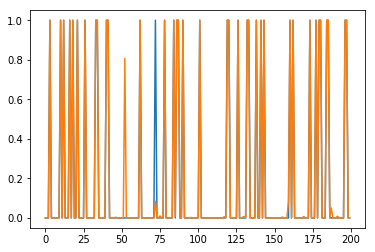

In [48]:
plt.plot(sub_validation_truth[0:200,0])
plt.plot(results[0:200,0])

In [49]:
bads=np.argwhere(np.round(results[:,0])!=sub_validation_truth[:,0])

In [50]:
bads

array([[ 52],
       [ 72],
       [266],
       [471],
       [487],
       [594],
       [847],
       [914],
       [998]])

[1.0, 0.00018002509]

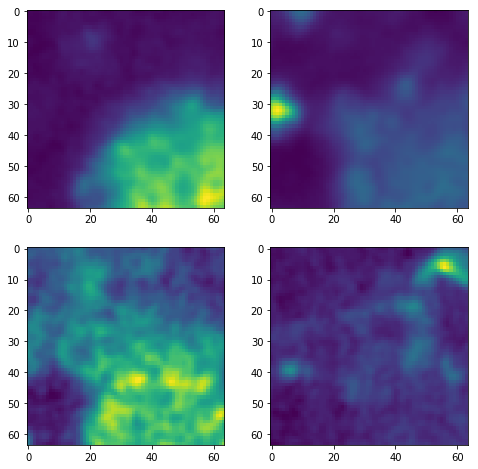

In [36]:
ix=983
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

# Look at whole image bone 2 081516

In [37]:
sub_validation_data=true_test_data[0:8000, :,:,:]
sub_validation_truth=validation_truth[0:8000, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})

In [38]:
np.argwhere(np.round(results[:,0]))

array([[  62],
       [ 719],
       [ 720],
       [ 727],
       [ 933],
       [ 934],
       [ 935],
       [ 936],
       [ 937],
       [ 941],
       [ 942],
       [ 943],
       [ 944],
       [2225],
       [2393],
       [2448],
       [2449],
       [2609],
       [2610],
       [2663],
       [2664],
       [2665],
       [2666],
       [2674],
       [2675],
       [2676],
       [2677],
       [2678],
       [2679],
       [2680],
       [2891],
       [2892],
       [2893],
       [2894],
       [2895],
       [2896],
       [2897],
       [3536],
       [3537],
       [3538],
       [3539],
       [3540],
       [3541],
       [3756],
       [3757],
       [7386],
       [7387],
       [7388],
       [7389],
       [7390],
       [7391],
       [7393],
       [7394],
       [7395],
       [7396],
       [7397],
       [7398],
       [7399],
       [7400],
       [7401],
       [7402],
       [7403],
       [7404],
       [7405],
       [7474],
       [7608]])

[0.0, 0.9999411]

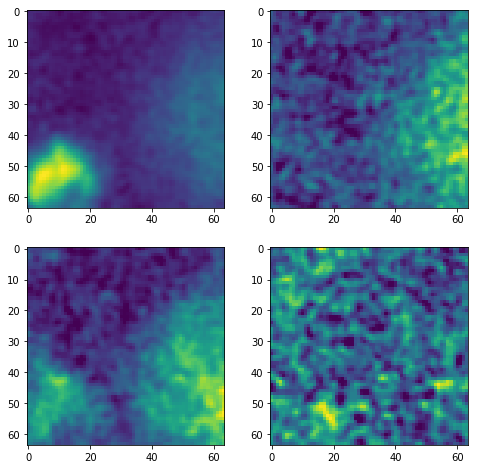

In [178]:
ix=888
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

# Look at whole image bone 2 13 081516

In [67]:
sub_validation_data=true_test2_data[48000:56000, :,:,:]
sub_validation_truth=validation_truth[0:8000, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})

In [68]:
np.argwhere(np.round(results[:,0]))

array([[ 622],
       [1182],
       [1183],
       [1587],
       [1588],
       [1589],
       [1590],
       [1591],
       [1592],
       [1593],
       [1594],
       [1595],
       [1737],
       [2048],
       [2049],
       [2050],
       [2299],
       [2300],
       [2301],
       [2302],
       [2306],
       [3167],
       [3168],
       [3169],
       [3170],
       [3171],
       [3172],
       [3173],
       [3174],
       [3175],
       [3176],
       [3177],
       [3279],
       [3328],
       [3329],
       [3631],
       [3632],
       [3633],
       [3634],
       [3635],
       [3636],
       [3830],
       [3831],
       [3832],
       [4041],
       [4042],
       [4091],
       [4858],
       [4859],
       [4860],
       [4861],
       [4862],
       [4957],
       [4958],
       [4959],
       [5011],
       [5410],
       [5411],
       [5412],
       [5413],
       [5414],
       [5671],
       [5672],
       [6389],
       [6390],
       [6391],
       [63

[0.0, 0.9999254]

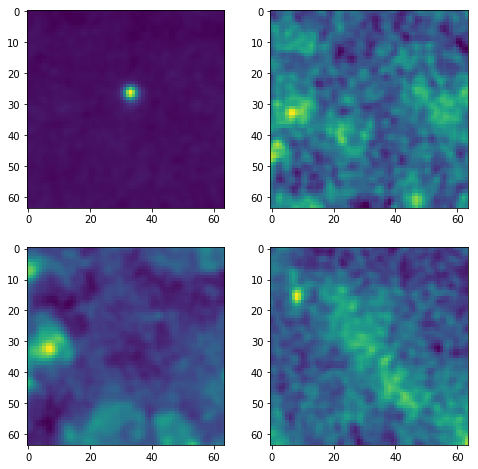

In [58]:
ix=7067
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]